# **Import**

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# !pip install keras-tcn
from tcn import TCN

from tensorflow.keras.callbacks import EarlyStopping

# **Data Load**

In [3]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD001.txt',
                       sep='\s+',
                       header=None,
                       index_col=False,
                       names=col_names)

In [5]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

In [6]:
train_df.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


# **RUL Clipping**

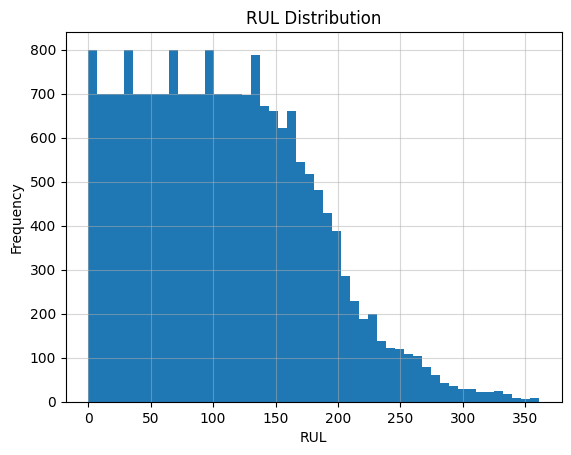

In [7]:
# Clipping 기준: RUL이 125~200 사이 지점에서 급격히 줄어드는 것을 확인 할 수 있음.
# 125~200 사이에서 Clipping 후 모델 성능 확인 필요
rul = train_df['RUL'].values
plt.hist(rul, bins=50)
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.title('RUL Distribution')
plt.grid(alpha=0.5)
plt.show()

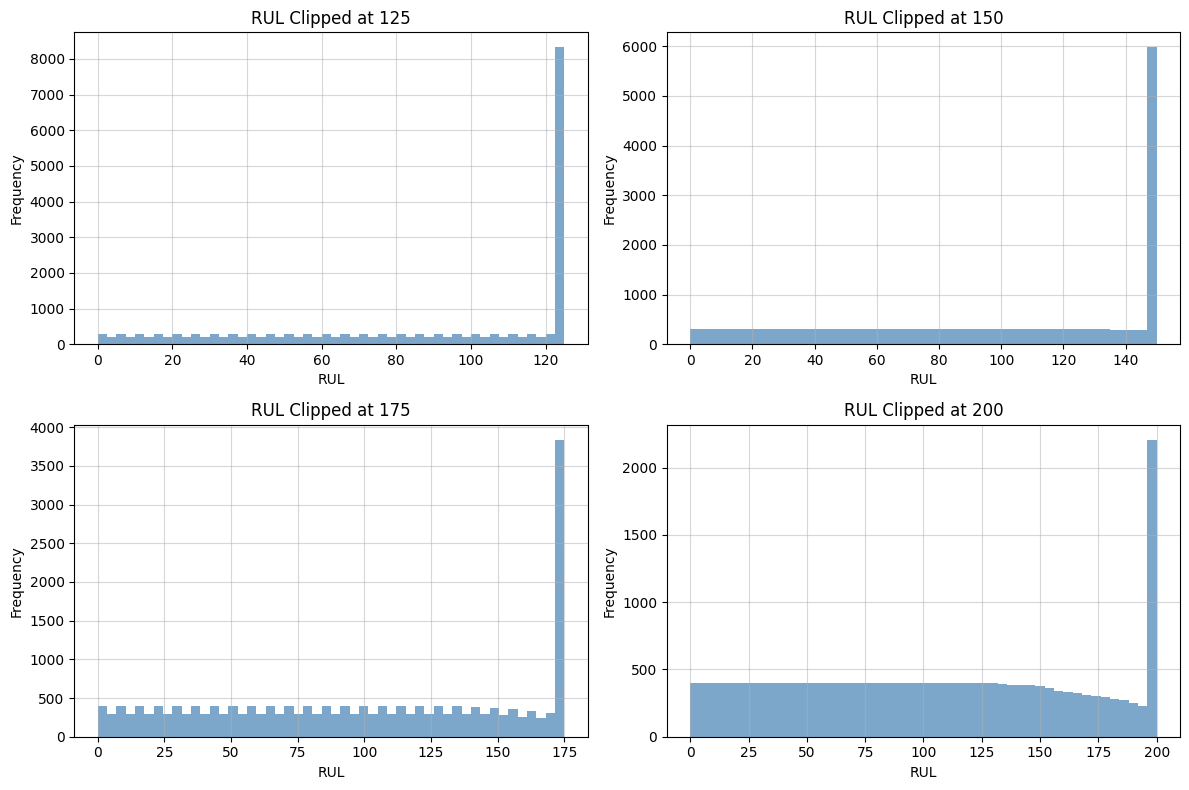

In [8]:
RUL_clip_values = [125, 150, 175, 200]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, value in enumerate(RUL_clip_values):
    rul_clipped = train_df['RUL'].clip(upper=value)

    axes[i].hist(rul_clipped, bins=50, color='steelblue', alpha=0.7)
    axes[i].set_title(f'RUL Clipped at {value}')
    axes[i].set_xlabel('RUL')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

# **Model**

In [9]:
def create_sequences_with_clip(df, sensor_names, window_size=30, clip_value=125, scaler=None):

    x, y = [], []
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.transform(df[sensor_names])

    # ✅ RUL 클리핑 추가
    df_scaled['RUL'] = np.clip(df_scaled['RUL'], a_min=None, a_max=clip_value)

    # 유닛별로 시퀀스 생성
    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = unit_data['RUL'].values

        for i in range(len(unit_data) - window_size):
            x.append(sensors[i:i+window_size])
            y.append(rul[i+window_size])

    return np.array(x), np.array(y)


In [10]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


## **LSTM**

In [24]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

scaler = MinMaxScaler()
scaler.fit(train_df[sensor_names])

RUL_clip_values = [125, 150, 175, 200, None]

unit_ids = train_df['unit_number'].unique()

# Train:Val = 8:2
unit_groups = [unit_ids[i:i+10] for i in range(0, len(unit_ids), 10)]

In [25]:
summary_results = []

for clip_value in RUL_clip_values:
    fold_metrics = []
    clip_label = clip_value if clip_value is not None else "Original"

    for fold_idx, val_units in enumerate(unit_groups, 1):
        # train/val split (unit 단위)
        train_units = [u for u in unit_ids if u not in val_units]
        train_mask = train_df['unit_number'].isin(train_units)
        val_mask = train_df['unit_number'].isin(val_units)

        # 시퀀스 생성
        x_train, y_train = create_sequences_with_clip(train_df[train_mask], sensor_names, window_size, clip_value)
        x_val, y_val = create_sequences_with_clip(train_df[val_mask], sensor_names, window_size, clip_value)

        input_shape = (x_train.shape[1], x_train.shape[2])

        # LSTM 모델 정의
        lstm_model = Sequential([
            LSTM(64, input_shape=input_shape, return_sequences=False),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')

        # 학습
        lstm_model.fit(
            x_train, y_train,
            epochs=30,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=0
        )

        # 예측 및 성능 계산
        lstm_pred = lstm_model.predict(x_val, verbose=0)
        lstm_rmse = np.sqrt(mean_squared_error(y_val, lstm_pred))
        lstm_mae = mean_absolute_error(y_val, lstm_pred)

        fold_metrics.append((lstm_rmse, lstm_mae))

    # ✅ fold 평균 계산
    mean_rmse = np.mean([rmse for rmse, _ in fold_metrics])
    mean_mae = np.mean([mae for _, mae in fold_metrics])
    print(f"Clip Value {clip_label} → RMSE: {mean_rmse:.3f}, MAE: {mean_mae:.3f}")

    summary_results.append({
        'Clip_Value': clip_label,
        'Mean_RMSE': mean_rmse,
        'Mean_MAE': mean_mae
    })

Clip Value 125 → RMSE: 14.529, MAE: 11.047
Clip Value 150 → RMSE: 19.105, MAE: 14.784
Clip Value 175 → RMSE: 23.097, MAE: 17.738
Clip Value 200 → RMSE: 25.973, MAE: 19.661
Clip Value Original → RMSE: 30.133, MAE: 22.254


In [26]:
results_df = pd.DataFrame(summary_results)
print(results_df)

  Clip_Value  Mean_RMSE   Mean_MAE
0        125  14.529023  11.047136
1        150  19.104678  14.784273
2        175  23.097025  17.738097
3        200  25.973232  19.660665
4   Original  30.133136  22.253668


## **TCN**

In [27]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

scaler = MinMaxScaler()
scaler.fit(train_df[sensor_names])

RUL_clip_values = [125, 150, 175, 200, None]

unit_ids = train_df['unit_number'].unique()

# Train:Val = 8:2
unit_groups = [unit_ids[i:i+10] for i in range(0, len(unit_ids), 10)]

In [28]:
summary_results = []

for clip_value in RUL_clip_values:
    fold_metrics = []
    clip_label = clip_value if clip_value is not None else "Original"

    for fold_idx, val_units in enumerate(unit_groups, 1):

        # train/val split (unit 단위)
        train_units = [u for u in unit_ids if u not in val_units]
        train_mask = train_df['unit_number'].isin(train_units)
        val_mask = train_df['unit_number'].isin(val_units)

        # 시퀀스 생성
        x_train, y_train = create_sequences_with_clip(train_df[train_mask], sensor_names, window_size, clip_value)
        x_val, y_val = create_sequences_with_clip(train_df[val_mask], sensor_names, window_size, clip_value)

        input_shape = (x_train.shape[1], x_train.shape[2])

        # TCN 모델 정의
        tcn_model = Sequential([
            TCN(
                input_shape=input_shape,
                nb_filters=64,
                kernel_size=3,
                dilations=[1,2,4,8],
                dropout_rate=0.1,
                activation='relu',
                use_skip_connections=True,
                return_sequences=False
            ),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        tcn_model.compile(optimizer='adam', loss='mse')

        # 학습
        tcn_model.fit(
            x_train,
            y_train,
            epochs=30,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=0
        )

        # 예측 및 성능 계산
        tcn_pred = tcn_model.predict(x_val, verbose=0)
        tcn_rmse = np.sqrt(mean_squared_error(y_val, tcn_pred))
        tcn_mae = mean_absolute_error(y_val, tcn_pred)

        fold_metrics.append((tcn_rmse, tcn_mae))

    # fold 평균 계산
    mean_rmse = np.mean([rmse for rmse, _ in fold_metrics])
    mean_mae = np.mean([mae for _, mae in fold_metrics])
    print(f"Clip Value {clip_label} → Mean RMSE: {mean_rmse:.3f}, Mean MAE: {mean_mae:.3f}")

    summary_results.append({
        'Clip_Value': clip_label,
        'Mean_RMSE': mean_rmse,
        'Mean_MAE': mean_mae
    })

Clip Value 125 → Mean RMSE: 15.014, Mean MAE: 11.624
Clip Value 150 → Mean RMSE: 19.093, Mean MAE: 14.800
Clip Value 175 → Mean RMSE: 22.225, Mean MAE: 16.876
Clip Value 200 → Mean RMSE: 24.665, Mean MAE: 18.562
Clip Value Original → Mean RMSE: 29.731, Mean MAE: 21.602


# **Predict RUL**

In [11]:
window_size = 30
clip_value = 125
sensor_names = [c for c in train_df.columns if 's_' in c]

unit_ids = train_df['unit_number'].unique()

In [12]:
scaler = MinMaxScaler()
scaler.fit(train_df[sensor_names])

train_units, val_units = train_test_split(unit_ids, test_size=0.2, random_state=42)

train_mask = train_df['unit_number'].isin(train_units)
val_mask = train_df['unit_number'].isin(val_units)

x_train, y_train = create_sequences_with_clip(train_df[train_mask], sensor_names, window_size, clip_value, scaler)
x_val, y_val = create_sequences_with_clip(train_df[val_mask], sensor_names, window_size, clip_value, scaler)

In [13]:
input_shape = (x_train.shape[1], x_train.shape[2])

final_lstm = Sequential([
    LSTM(64, input_shape=input_shape, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
final_lstm.compile(optimizer='adam', loss='mae')

final_lstm.fit(
    x_train, y_train,
    epochs=500,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 67.2581 - val_loss: 37.2877
Epoch 2/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 36.7720 - val_loss: 36.8070
Epoch 3/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 36.8575 - val_loss: 35.6340
Epoch 4/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 28.0942 - val_loss: 14.6690
Epoch 5/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.3237 - val_loss: 9.9155
Epoch 6/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 11.2757 - val_loss: 9.2477
Epoch 7/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.6946 - val_loss: 9.7115
Epoch 8/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.6301 - val_loss: 10.3226
Epoch 9/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.3301 - val_loss: 8.5587
Epoch 10/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.8813 - val_loss: 8.7674
Epoch 11/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.0552 - val_loss: 10.2109
Epoch 12/500
222/222 ━━━━

In [14]:
final_tcn = Sequential([
    TCN(input_shape=input_shape,
        nb_filters=64, kernel_size=3, dilations=[1,2,4,8],
        dropout_rate=0.1, activation='relu', use_skip_connections=True,
        return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
final_tcn.compile(optimizer='adam', loss='mae')

final_tcn.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 33.9508 - val_loss: 12.9208
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.8983 - val_loss: 16.4278
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.7544 - val_loss: 16.9697
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.9015 - val_loss: 14.6014
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.4236 - val_loss: 11.4235
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.3929 - val_loss: 11.9575
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 12.4847 - val_loss: 11.2419
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 12.1900 - val_loss: 12.3026
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.0314 - val_loss: 11.3239
Epoch 10/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.6609 - val_loss: 10.5378
Epoch 11/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.5719 - val_loss: 10.5151
Epoch 12/100
222/

In [15]:
x_all, y_all = create_sequences_with_clip(train_df, sensor_names, window_size, clip_value, scaler)
lstm_pred_all = final_lstm.predict(x_all, verbose=1)
tcn_pred_all = final_tcn.predict(x_all, verbose=1)

551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


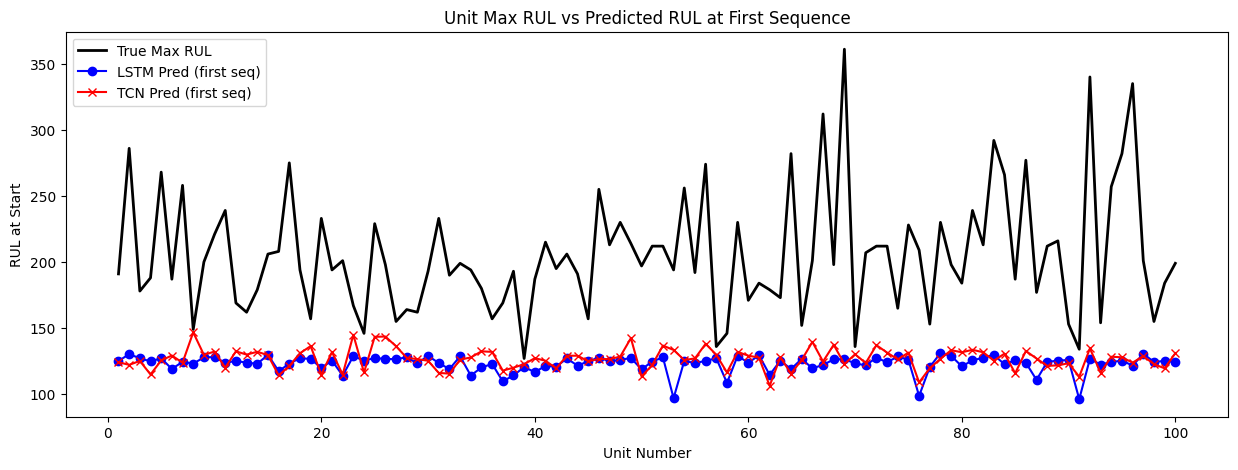

In [44]:
unit_ids = train_df['unit_number'].unique()

true_max_rul = []
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    unit_len = len(train_df[train_df['unit_number'] == unit])

    max_rul = train_df[train_df['unit_number'] == unit]['RUL'].max()
    true_max_rul.append(max_rul)

    first_seq_idx = start_idx
    lstm_rul_start.append(lstm_pred_all[first_seq_idx][0])
    tcn_rul_start.append(tcn_pred_all[first_seq_idx][0])

    start_idx += unit_len - window_size

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.show()

# **Test**

In [20]:
test_df = pd.read_csv('./test_FD001.csv')
rul_df = pd.read_csv('./RUL_FD001.csv')

In [21]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [28]:
sensor_names = [c for c in test_df.columns if 's_' in c]
window_size = 30

def create_test_sequences(df, sensor_names, window_size, scaler=None):
    x_test, y_test = [], []
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.transform(df[sensor_names])

    unit_max_rul = []

    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = np.arange(len(unit_data)-1, -1, -1)  # Test set RUL: 마지막부터 1씩 감소

        # window_size 마지막 시퀀스만 사용 (혹은 sliding 가능)
        if len(unit_data) >= window_size:
            x_test.append(sensors[-window_size:])
            y_test.append(rul[-1])  # 마지막 시점 RUL
        else:
            # window_size보다 작은 경우 패딩 (앞쪽 반복)
            pad = np.repeat(sensors[0:1], window_size - len(unit_data), axis=0)
            x_test.append(np.vstack([pad, sensors]))
            y_test.append(rul[-1])

        unit_max_rul.append(rul[-1])

    return np.array(x_test), np.array(y_test), unit_max_rul

x_test_seq, y_test_seq, unit_max_rul = create_test_sequences(test_df, sensor_names, window_size, scaler)

In [38]:
clip_value = 125
y_test = rul_df['RUL']

In [39]:
lstm_pred_test = final_lstm.predict(x_test_seq)

lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred_test))
lstm_mae = mean_absolute_error(y_test, lstm_pred_test)
print(f"RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
RMSE: 15.144, MAE: 11.397


In [40]:
tcn_pred_test = final_tcn.predict(x_test_seq)

tcn_rmse = np.sqrt(mean_squared_error(y_test, tcn_pred_test))
tcn_mae = mean_absolute_error(y_test, tcn_pred_test)
print(f"RMSE: {tcn_rmse:.3f}, MAE: {tcn_mae:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
RMSE: 16.183, MAE: 11.642


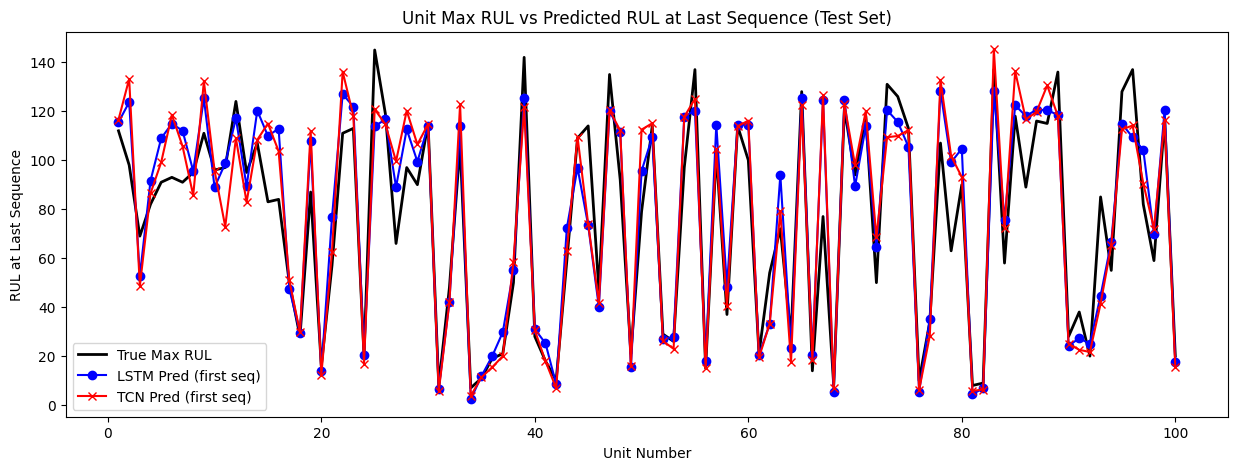

In [41]:
unit_ids = test_df['unit_number'].unique()

true_max_rul = rul_df['RUL'].values.tolist()  # Test set 실제 RUL
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    # unit별 시퀀스 개수
    unit_len = len(x_test_seq[start_idx:]) if len(x_test_seq[start_idx:]) == 1 else 1  # 마지막 시퀀스만 사용
    lstm_rul_start.append(lstm_pred_test[start_idx][0])
    tcn_rul_start.append(tcn_pred_test[start_idx][0])
    start_idx += unit_len

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Last Sequence')
plt.title('Unit Max RUL vs Predicted RUL at Last Sequence (Test Set)')
plt.legend()
plt.show()